In [2]:
# Import packages

from scipy.interpolate import interp1d
import time
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
get_ipython().run_line_magic('matplotlib', 'inline')
import datetime
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import matplotlib.ticker as plticker
import bisect
import copy
import json
import csv
import ast
import pylab as pl
import time
from scipy.special import erf
from scipy import integrate
from scipy.integrate import quad, dblquad
from scipy.integrate import simps



In [3]:
# Lists of colors for plots

c0 = (0.76, 0.76, 0.76)
c1 = (1.00, 0.18, 0.33);
c2 = (1.00, 0.23, 0.19);
c3 = (1.00, 0.58, 0.00);
c4 = (1.00, 0.80, 0.00);
c5 = (0.30, 0.85, 0.39);
c6 = (0.35, 0.78, 0.98);
c7 = (0.20, 0.67, 0.86);
c8 = (0.00, 0.48, 1.00);
c9 = (0.35, 0.34, 0.84);
c10 = (0.00, 0.31, 0.57);
c11 = (0.12, 0.29, 0.69);
c12 = (0.17, 0.17, 0.42);
c13 = (1.00, 1.00, 1.00);
c14 = (0.77, 0.04, 0.00);

ios_colors=[c5, c1, c3, c7, c2, c6, c4, c9, c8]

def to_rgb_frac(vect):
    return (float(vect[0])/255, float(vect[1])/255, float(vect[2])/255)

color_list=list(map(to_rgb_frac, [(166,206,227),(178,223,138),(51,160,44),(31,120,180)]))

# Lists of colors for plots

def to_rgb_frac(vect):
    return (float(vect[0])/255, float(vect[1])/255, float(vect[2])/255)

rb_div_5=list(map(to_rgb_frac, [(202,0,32),
(244,165,130),
(247,247,247),
(146,197,222),
(5,113,176)]))

qualitative_10=list(map(to_rgb_frac, [(166,206,227),
(31,120,180),
(178,223,138),
(51,160,44),
(251,154,153),
(227,26,28),
(253,191,111),
(255,127,0),
(202,178,214),
(106,61,154)]))



#define the colors from colorbrewer2
orange1 = '#feedde'
orange2 = '#fdbe85'
orange3 = '#fd8d3c'
orange4 = '#e6550d'
orange5 = '#a63603'
blue1 = '#eff3ff'
blue2 = '#bdd7e7'
blue3 = '#6baed6'
blue4 = '#3182bd'
blue5 = '#08519c'
green1 = '#edf8e9'
green2 = '#bae4b3'
green3 = '#74c476'
green4 = '#31a354'
green5 = '#006d2c'
grey1 = '#f7f7f7'
grey2 = '#cccccc'
grey3 = '#969696'
grey4 = '#636363'
grey5 = '#252525'
purple1 = '#f2f0f7'
purple2 = '#cbc9e2'
purple3 = '#9e9ac8'
purple4 = '#756bb1'
purple5 = '#54278f'
red1 = '#fee5d9'
red2 = '#fcae91'
red3 = '#fb6a4a'
red4 = '#de2d26'
red5 = '#a50f15'

### Define common DFE 

In [5]:
p_inferred = 3
q_inferred = 0.1
s_max_inferred = float('inf')

weight_s= lambda s: np.exp(-((abs(s))/q_inferred)**p_inferred)
normalization=integrate.quad(weight_s, 0.0, float("inf"))[0]



best_fit_haploid_driver_rate_blood = 1.9482421874998532e-05
N_tau_blood = 10**5

best_fit_haploid_driver_rate_oesophagus = 0.0003478124999999994  
N_tau_oesophagus = 10**4

### Define theory functions

In [6]:
s_tolerance = 3.5/100
print('The DFE has a lower cutt off at s=', s_tolerance)

The DFE has a lower cutt off at s= 0.035


In [7]:
#  theory functions for passengers
import scipy.special as sc

def hitchhikers_exponential_feeding_with_cutoff(l, N_tau, t, u_driver, s):
    
    N = N_tau
    
    #     inserted factor of 2 to account for diploidy
    expected_density=2*np.exp(l)*(2*N/(1-2*np.exp(l))**2)*N*u_driver/s**2/(2*N*np.exp(l)/(1-2*np.exp(l)))**2*\
    (np.exp(-(2*N*np.exp(l)/(1-2*np.exp(l)))*s*np.exp(-s*t))*np.exp(s*t)        -\
     np.exp(-(2*N*np.exp(l)/(1-2*np.exp(l)))*s)*(np.exp(s*t)+ (2*N*np.exp(l)/(1-2*np.exp(l)))*s*(np.exp(s*t)-1)  ))

    return expected_density

def minor_contribution_hitchhikers_alternative_theory_with_cutoff(l, N_tau, t, u_driver, s):
    N=N_tau
    tau=1
    
    #     inserted factor of 2 to account for diploidy
    expected_density=2*np.exp(l)*N*tau*u_driver/(np.exp(l)*s*(1-2*np.exp(l)))*(-s*t*np.exp(-(2*N*np.exp(l)/(1-2*np.exp(l)))*s*tau)+sc.expi(-(2*N*np.exp(l)/(1-2*np.exp(l)))*s*tau) -\
                                                   sc.expi(-(2*N*np.exp(l)/(1-2*np.exp(l)))*s*tau*np.exp(-s*t)))
    

    return expected_density


# for passengers driven by discrete drivers
def expected_density_hitchhiker_mutants_s_discrete(t, l, s1, mu_ben, N_tau):

#     psi = np.log(N_tau*s1+1)/s1
    relative_fitness=0.05
    psi = np.log((s1/relative_fitness-1)*N_tau*s1+1)/s1
    
    if t>psi:
        density = hitchhikers_exponential_feeding_with_cutoff(l, N_tau, psi, mu_ben, s1)+\
        + minor_contribution_hitchhikers_alternative_theory_with_cutoff(l, N_tau, psi, mu_ben, s1)

    else:
        density = hitchhikers_exponential_feeding_with_cutoff(l, N_tau, t, mu_ben, s1)+\
        + minor_contribution_hitchhikers_alternative_theory_with_cutoff(l, N_tau, t, mu_ben, s1)
    
    return density

def linProbtheory_actual_ages_hitch_discrete(l, s1, mu_ben, N_tau, list_of_control_ages): #= predicted density (i.e. normalised by 2 x mu)
    "Natural log of the probability of observing a variant within a specific binwidth if able to sequence perfectly"
    total_density=0.0
    
    for i in range(len(list_of_control_ages)):
        age = list_of_control_ages[i]
        total_density= total_density + expected_density_hitchhiker_mutants_s_discrete(age, l, s1, mu_ben, N_tau)/len(list_of_control_ages)
    
    return total_density

def logProbtheory_actual_ages_hitch_discrete(l, s1, mu_ben, N_tau, list_of_control_ages): #= predicted density (i.e. normalised by 2 x mu)
    "Natural log of the probability of observing a variant within a specific binwidth if able to sequence perfectly"
    total_density=0.0
    
    for i in range(len(list_of_control_ages)):
        age = list_of_control_ages[i]
        total_density= total_density + expected_density_hitchhiker_mutants_s_discrete(age, l, s1, mu_ben, N_tau)/len(list_of_control_ages)
    
    
    return np.log(total_density)

# for passengers driven by drivers from a DFE
def expected_density_hitchhiker_mutants_DFE(t, l, s1, b, d, mu_ben, N_tau):
    
    u_driver_at_s1 = mu_ben*np.exp(-((abs(s1))/d)**b)/normalization

#     psi = np.log(N_tau*s1+1)/s1
    relative_fitness=0.05
    psi = np.log((s1/relative_fitness-1)*N_tau*s1+1)/s1
    
    if t>psi:
        density = hitchhikers_exponential_feeding_with_cutoff(l, N_tau, psi, u_driver_at_s1, s1)+\
        + minor_contribution_hitchhikers_alternative_theory_with_cutoff(l, N_tau, psi, u_driver_at_s1, s1)

    else:
        density = hitchhikers_exponential_feeding_with_cutoff(l, N_tau, t, u_driver_at_s1, s1)+\
        + minor_contribution_hitchhikers_alternative_theory_with_cutoff(l, N_tau, t, u_driver_at_s1, s1)
    
    return density

def expected_number_hitchhiker_mutants_DFE(t, l, b, d, mu_ben, s_lower, s_upper, N_tau):
    
    result = integrate.quad(lambda s_var: expected_density_hitchhiker_mutants_DFE(t,  l, s_var,\
                                                                        b, d, mu_ben, N_tau), s_lower, s_upper)[0]

    return result

def logProbtheory_actual_ages_hitch_DFE(l, params, N_tau, s_lower, s_upper, list_of_control_ages): #= predicted density (i.e. normalised by 2 x mu)
    "Natural log of the probability of observing a variant within a specific binwidth if able to sequence perfectly"
    total_density=0.0
    
    b = params[0] 
    d = params[1]
    mu_ben= params[2]
    
    for i in range(len(list_of_control_ages)):
        age = list_of_control_ages[i]
        total_density= total_density + expected_number_hitchhiker_mutants_DFE(age, l, b, d, mu_ben, s_lower, s_upper, N_tau)/len(list_of_control_ages)


    return np.log(total_density)

def linProbtheory_actual_ages_hitch_DFE(l, params, N_tau, s_lower, s_upper, list_of_control_ages): #= predicted density (i.e. normalised by 2 x mu)
    "Natural log of the probability of observing a variant within a specific binwidth if able to sequence perfectly"
    total_density=0.0
    
    b = params[0] 
    d = params[1]
    mu_ben= params[2]
    
    for i in range(len(list_of_control_ages)):
        age = list_of_control_ages[i]
        total_density= total_density + expected_number_hitchhiker_mutants_DFE(age, l, b, d, mu_ben, s_lower, s_upper, N_tau)/len(list_of_control_ages)

    return total_density

def linProbtheory_actual_ages_hitch_DFE_for_oesophagus_samples(l, params, N_tau, s_lower, s_upper, Martincorena_donor_ages, list_of_n_samples_per_person, n_sample): #= predicted density (i.e. normalised by 2 x mu)
    "Natural log of the probability of observing a variant within a specific binwidth if able to sequence perfectly"
    total_density=0.0
    
    b = params[0] 
    d = params[1]
    mu_ben= params[2]
    
    result = 0
    for j in range(len(Martincorena_donor_ages)):

        age = Martincorena_donor_ages[j]
        total_density= total_density + expected_number_hitchhiker_mutants_DFE(age, l, b, d, mu_ben, s_lower, s_upper, N_tau)*list_of_n_samples_per_person[j]/n_sample
    

    return total_density


In [8]:
#  theory functions for drift and developmental mutations
def logProbtheory_actual_ages_drift(l, N_tau, list_of_control_ages):
    u_neu=1/2
    density = 0
    
    for i in range(len(list_of_control_ages)):
        t = list_of_control_ages[i]
        density = density + 2*N_tau/(1-2*np.exp(l))*u_neu*np.exp(-2*N_tau/(t)*(np.exp(l)/(1-2*np.exp(l))))/len(list_of_control_ages)
    
    
    return np.log(density)

def logProbtheory_ages_dev(l, u_dev, u_norm):
    
    norm=2*u_norm 
    
    density= 2*u_dev/(np.log(2)*(2*np.exp(l))**1)/norm             

    return np.log(density)

def linProbtheory_ages_dev(l, u_dev, u_norm):
    
    norm=2*u_norm 
    
    density= 2*u_dev/(np.log(2)*(2*np.exp(l))**1)/norm             

    return density


In [9]:
# plotting functions

def error_bars(hist, normed_value, widths):
    
    errors={}
    n=0
    for i in list(hist):
        normalised_hist = i/(normed_value*widths)
        log_hist = np.log(normalised_hist)
        sqrt_hist = math.sqrt(i)
        if sqrt_hist == 1:
            upper_error = 1
            lower_error = 0.9
        if sqrt_hist !=1:
            upper_error = sqrt_hist
            lower_error = sqrt_hist
        normalised_upper_error = upper_error/(normed_value*widths)
        normalised_lower_error = lower_error/(normed_value*widths)
#         print('normalised_hist is of type', type(normalised_hist))
        errors[n]=(normalised_hist[0], normalised_upper_error[0], normalised_lower_error[0])
        n = n+1

    errors_corrected ={}
    for k, v in errors.items():
        binheight = v[0]
        log_binheight = np.log(v[0])
        upper_error = v[1]
        lower_error = v[2]
        log_upper_error = (np.log(upper_error+binheight))-log_binheight
        log_lower_error = log_binheight-(np.log(binheight-lower_error))
        errors_corrected[k] = (log_binheight, log_upper_error, log_lower_error)

    lower_err=[]
    upper_err=[]
    for k, v in errors_corrected.items():
        lower_error = v[2]
        upper_error = v[1]
        lower_err.append(lower_error)
        upper_err.append(upper_error)

    err = [tuple(lower_err),tuple(upper_err)]
    
    return err

def plot_log_hist_data_rcumulative_not_divided_by_binsize(study_VAFs, study_total, n_bins, lmin, lmax, study_name, marker_name, marker_size, color, scale):
    
    # create logged list
    log_VAFs = []
    for i in study_VAFs:
        log_VAFs.append(np.log(float(i)))
    
    
    normed_value = study_total
#     create a list of n_bins bin positions 'bins' and bin values 'hist'
    hist, bins = np.histogram(log_VAFs,  bins=np.linspace(lmin, lmax, n_bins))
#     should be constant binwidth
    widths = np.diff(bins)
    print('widths', type(widths))
    bin_centres = (bins[:-1] + bins[1:])/2

#     the bin values are turned into reverse cumulative
    hist=np.cumsum(hist[::-1])[::-1]
#     then normalized not by binwidth
    normalised_hist = hist/(normed_value)
#     then logged
#     normalised_hist = hist/(normed_value*width_scalar)
    log_hist_for_plot = np.log(normalised_hist)
    
#     widths_holder set to 1 for cumulative plots
    widths_holder = []
    for value in widths:
        widths_holder.append(int(1))
    widths_holder=np.array(widths_holder)
    print('widths_holder', type(widths_holder))
    errors = error_bars(hist, normed_value, widths_holder)
    
#     scale=1.2
    axisfont=14*scale
    axislabelfont=15*scale
    tpfont = 14*scale

    m_size = 15*1.2
    m_width = 1.5*1.2
    c_size = 7*1.2
    c_thick = 3*1.2
    e_width = 1.5*1.2

    ax1.errorbar(bin_centres, log_hist_for_plot, yerr= errors, fmt = marker_name, ecolor = grey5, \
                 elinewidth = e_width, capsize = c_size, capthick = c_thick, markersize = marker_size, markeredgewidth = m_width, \
                 markeredgecolor = grey5, markerfacecolor = color, label = study_name, zorder=3)
    

    
    print('log_hist_for_plot is', log_hist_for_plot)
    print('errors is', errors)
    
    # Set axis limits
    print('min(log_hist_for_plot)',min(log_hist_for_plot))
    print('max(log_hist_for_plot)',max(log_hist_for_plot))

    ax1.set_xlim(np.log(10**-3), 0)

    

    x_major_ticks =  [np.log(0.001), np.log(0.002),np.log(0.003),np.log(0.004),np.log(0.005),np.log(0.006),np.log(0.007),np.log(0.008),np.log(0.009), \
                     np.log(0.01),np.log(0.02),np.log(0.03),np.log(0.04),np.log(0.05),np.log(0.06),np.log(0.07),np.log(0.08),np.log(0.09),\
                     np.log(0.1),np.log(0.2),np.log(0.3),np.log(0.4),np.log(0.5),np.log(0.6),np.log(0.7),np.log(0.8),np.log(0.9), np.log(1.0)]

                    
    x_major_tick_labels =  [ "0.1","","","","","","","","",\
                           "1","","","","","","","","",\
                           "10","","","","50","","","","",""]

                         
    ax1.set_xticks(x_major_ticks)
    ax1.set_xticklabels(x_major_tick_labels, fontsize = axisfont)
    ax1.xaxis.set_tick_params(width=scale, color = grey3, length = 6)
    
    # Axis labels
    ax1.set_xlabel('variant allele frequency (%)', fontsize = 20, labelpad = 4*scale, fontweight = 'medium')
    ax1.set_ylabel('reverse cumulative probability', fontsize = 20, labelpad = 6*scale, fontweight = 'medium')

    y_major_ticks = [np.log(100), np.log(200), np.log(300), \
                     np.log(400), np.log(500), np.log(600),\
                     np.log(700), np.log(800), np.log(900), \
                     np.log(1000), np.log(2000), np.log(3000),\
                    np.log(4000), np.log(5000), np.log(6000), \
                     np.log(7000), np.log(8000), np.log(9000),\
                    np.log(10000), np.log(20000), np.log(30000), \
                     np.log(40000), np.log(50000), np.log(60000),\
                    np.log(70000), np.log(80000), np.log(90000), \
                     np.log(100000), np.log(200000),np.log(300000),np.log(400000),np.log(500000),np.log(600000),\
                    np.log(700000),np.log(800000),np.log(900000),np.log(1000000)\
                    , np.log(2000000),np.log(3000000),np.log(4000000),np.log(5000000),np.log(6000000),\
                    np.log(7000000),np.log(8000000),np.log(9000000),np.log(10000000)\
                    , np.log(20000000),np.log(30000000),np.log(40000000),np.log(50000000),np.log(60000000),\
                    np.log(70000000),np.log(80000000),np.log(90000000),np.log(100000000)]
    
    y_major_ticks = [c-np.log(10**3) for c in y_major_ticks]
    y_major_tick_labels = ["" ,"", "", "", "", "", "", "", "", \
                           "$10^{0}$","", "", "", "", "", "", "", "", \
                           "$10^{1}$","", "", "", "", "", "", "", "", "$10^{2}$","", "", "", "", "", "", "", "", "$10^{3}$"\
                          ,"", "", "", "", "", "", "", "", "$10^{4}$","", "", "", "", "", "", "", "", "$10^{5}$"]
    ax1.set_yticks(y_major_ticks)
    ax1.set_yticklabels(y_major_tick_labels, fontsize = axisfont)
    ax1.yaxis.set_tick_params(width=scale, color = grey3, length = 6)

    #Only show the required axis lines
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    for axis in ['bottom','left']:
        ax1.spines[axis].set_linewidth(1.5)

    for axis in ['bottom','left']:
        ax1.spines[axis].set_color(grey3)

    return ax1

def plot_log_hist_data_rcumulative_not_divided_by_binsize_shift_to_left(study_VAFs, study_total, n_bins, lmin, lmax, study_name, marker_name, marker_size, color, scale):
    
    # create logged list
    log_VAFs = []
    for i in study_VAFs:
        log_VAFs.append(np.log(float(i)))
    
    
    normed_value = study_total
#     create a list of n_bins bin positions 'bins' and bin values 'hist'
    hist, bins = np.histogram(log_VAFs,  bins=np.linspace(lmin, lmax, n_bins))
#     should be constant binwidth
    widths = np.diff(bins)
    print('widths', type(widths))
    cumulative_bins = bins[0: len(bins)-1]
    bin_centres = (bins[:-1] + bins[1:])/2

#     the bin values are turned into reverse cumulative
    hist=np.cumsum(hist[::-1])[::-1]
#     then normalized not by binwidth
    normalised_hist = hist/(normed_value)
#     then logged
#     normalised_hist = hist/(normed_value*width_scalar)
    log_hist_for_plot = np.log(normalised_hist)
    
#     widths_holder set to 1 for cumulative plots
    widths_holder = []
    for value in widths:
        widths_holder.append(int(1))
    widths_holder=np.array(widths_holder)
    print('widths_holder', type(widths_holder))
    errors = error_bars(hist, normed_value, widths_holder)
    
#     scale=1.2
    axisfont=14*scale
    axislabelfont=15*scale
    tpfont = 14*scale

    m_size = 15*1.2
    m_width = 1.5*1.2
    c_size = 7*1.2
    c_thick = 3*1.2
    e_width = 1.5*1.2

    ax1.errorbar(cumulative_bins, log_hist_for_plot, yerr= errors, fmt = marker_name, ecolor = grey5, \
                 elinewidth = e_width, capsize = c_size, capthick = c_thick, markersize = marker_size, markeredgewidth = m_width, \
                 markeredgecolor = grey5, markerfacecolor = color, label = study_name, zorder=3)
    

    
    print('log_hist_for_plot is', log_hist_for_plot)
    print('errors is', errors)
    
    # Set axis limits
    print('min(log_hist_for_plot)',min(log_hist_for_plot))
    print('max(log_hist_for_plot)',max(log_hist_for_plot))

    ax1.set_xlim(np.log(10**-3), 0)

    

    x_major_ticks =  [np.log(0.001), np.log(0.002),np.log(0.003),np.log(0.004),np.log(0.005),np.log(0.006),np.log(0.007),np.log(0.008),np.log(0.009), \
                     np.log(0.01),np.log(0.02),np.log(0.03),np.log(0.04),np.log(0.05),np.log(0.06),np.log(0.07),np.log(0.08),np.log(0.09),\
                     np.log(0.1),np.log(0.2),np.log(0.3),np.log(0.4),np.log(0.5),np.log(0.6),np.log(0.7),np.log(0.8),np.log(0.9), np.log(1.0)]

                    
    x_major_tick_labels =  [ "0.1","","","","","","","","",\
                           "1","","","","","","","","",\
                           "10","","","","50","","","","",""]

                         
    ax1.set_xticks(x_major_ticks)
    ax1.set_xticklabels(x_major_tick_labels, fontsize = axisfont)
    ax1.xaxis.set_tick_params(width=scale, color = grey3, length = 6)
    
    # Axis labels
    ax1.set_xlabel('variant allele frequency (%)', fontsize = 20, labelpad = 4*scale, fontweight = 'medium')
    ax1.set_ylabel('reverse cumulative probability', fontsize = 20, labelpad = 6*scale, fontweight = 'medium')

    y_major_ticks = [np.log(100), np.log(200), np.log(300), \
                     np.log(400), np.log(500), np.log(600),\
                     np.log(700), np.log(800), np.log(900), \
                     np.log(1000), np.log(2000), np.log(3000),\
                    np.log(4000), np.log(5000), np.log(6000), \
                     np.log(7000), np.log(8000), np.log(9000),\
                    np.log(10000), np.log(20000), np.log(30000), \
                     np.log(40000), np.log(50000), np.log(60000),\
                    np.log(70000), np.log(80000), np.log(90000), \
                     np.log(100000), np.log(200000),np.log(300000),np.log(400000),np.log(500000),np.log(600000),\
                    np.log(700000),np.log(800000),np.log(900000),np.log(1000000)\
                    , np.log(2000000),np.log(3000000),np.log(4000000),np.log(5000000),np.log(6000000),\
                    np.log(7000000),np.log(8000000),np.log(9000000),np.log(10000000)\
                    , np.log(20000000),np.log(30000000),np.log(40000000),np.log(50000000),np.log(60000000),\
                    np.log(70000000),np.log(80000000),np.log(90000000),np.log(100000000)]
    
    y_major_ticks = [c-np.log(10**3) for c in y_major_ticks]
    y_major_tick_labels = ["" ,"", "", "", "", "", "", "", "", \
                           "$10^{0}$","", "", "", "", "", "", "", "", \
                           "$10^{1}$","", "", "", "", "", "", "", "", "$10^{2}$","", "", "", "", "", "", "", "", "$10^{3}$"\
                          ,"", "", "", "", "", "", "", "", "$10^{4}$","", "", "", "", "", "", "", "", "$10^{5}$"]
    ax1.set_yticks(y_major_ticks)
    ax1.set_yticklabels(y_major_tick_labels, fontsize = axisfont)
    ax1.yaxis.set_tick_params(width=scale, color = grey3, length = 6)

    #Only show the required axis lines
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    for axis in ['bottom','left']:
        ax1.spines[axis].set_linewidth(1.5)

    for axis in ['bottom','left']:
        ax1.spines[axis].set_color(grey3)

    return ax1

def plot_log_hist_data_rcumulative_rescaled_by_syn_rate_not_divided_by_binsize_shift_to_left(study_VAFs, study_total, u_syn, n_bins, lmin, lmax, study_name, marker_name, marker_size, color, scale):
    
    # create logged list
    log_VAFs = []
    for i in study_VAFs:
        log_VAFs.append(np.log(float(i)))
    
    
    normed_value = study_total*2*u_syn
#     create a list of n_bins bin positions 'bins' and bin values 'hist'
    hist, bins = np.histogram(log_VAFs,  bins=np.linspace(lmin, lmax, n_bins))
#     should be constant binwidth
    widths = np.diff(bins)
    print('widths', type(widths))
    cumulative_bins = bins[0: len(bins)-1]
    bin_centres = (bins[:-1] + bins[1:])/2

#     the bin values are turned into reverse cumulative
    hist=np.cumsum(hist[::-1])[::-1]
#     then normalized not by binwidth
    normalised_hist = hist/(normed_value)
#     then logged
#     normalised_hist = hist/(normed_value*width_scalar)
    log_hist_for_plot = np.log(normalised_hist)
    
#     widths_holder set to 1 for cumulative plots
    widths_holder = []
    for value in widths:
        widths_holder.append(int(1))
    widths_holder=np.array(widths_holder)
    print('widths_holder', type(widths_holder))
    errors = error_bars(hist, normed_value, widths_holder)
    
#     scale=1.2
    axisfont=14*scale
    axislabelfont=15*scale
    tpfont = 14*scale

    m_size = 15*1.2
    m_width = 1.5*1.2
    c_size = 7*1.2
    c_thick = 3*1.2
    e_width = 1.5*1.2

    ax1.errorbar(cumulative_bins, log_hist_for_plot, yerr= errors, fmt = marker_name, ecolor = grey5, \
                 elinewidth = e_width, capsize = c_size, capthick = c_thick, markersize = marker_size, markeredgewidth = m_width, \
                 markeredgecolor = grey5, markerfacecolor = color, label = study_name, zorder=3)
    

    
    print('log_hist_for_plot is', log_hist_for_plot)
    print('errors is', errors)
    
    # Set axis limits
    print('min(log_hist_for_plot)',min(log_hist_for_plot))
    print('max(log_hist_for_plot)',max(log_hist_for_plot))

    ax1.set_xlim(np.log(10**-3), 0)

    

    x_major_ticks = [np.log(0.0001),np.log(0.0002),np.log(0.0003),np.log(0.0004),np.log(0.0005),np.log(0.0006),np.log(0.0007),np.log(0.0008), np.log(0.0009),\
                     np.log(0.001), np.log(0.002),np.log(0.003),np.log(0.004),np.log(0.005),np.log(0.006),np.log(0.007),np.log(0.008),np.log(0.009), \
                     np.log(0.01),np.log(0.02),np.log(0.03),np.log(0.04),np.log(0.05),np.log(0.06),np.log(0.07),np.log(0.08),np.log(0.09),\
                     np.log(0.1),np.log(0.2),np.log(0.3),np.log(0.4),np.log(0.5),np.log(0.6),np.log(0.7),np.log(0.8),np.log(0.9), np.log(1.0)]
    x_major_tick_labels = ["0.01","","","","","","","","",\
                           "0.1","","","","","","","","",\
                           "1","","","","","","","","",\
                           "10","","","","50","","","","",""]

                         
    ax1.set_xticks(x_major_ticks)
    ax1.set_xticklabels(x_major_tick_labels, fontsize = axisfont)
    ax1.xaxis.set_tick_params(width=scale, color = grey3, length = 6)
    
    # Axis labels
    ax1.set_xlabel('variant allele frequency (%)', fontsize = 20, labelpad = 4*scale, fontweight = 'medium')
    ax1.set_ylabel('reverse cumulative probability', fontsize = 20, labelpad = 6*scale, fontweight = 'medium')

    y_major_ticks = [np.log(100), np.log(200), np.log(300), \
                     np.log(400), np.log(500), np.log(600),\
                     np.log(700), np.log(800), np.log(900), \
                     np.log(1000), np.log(2000), np.log(3000),\
                    np.log(4000), np.log(5000), np.log(6000), \
                     np.log(7000), np.log(8000), np.log(9000),\
                    np.log(10000), np.log(20000), np.log(30000), \
                     np.log(40000), np.log(50000), np.log(60000),\
                    np.log(70000), np.log(80000), np.log(90000), \
                     np.log(100000), np.log(200000),np.log(300000),np.log(400000),np.log(500000),np.log(600000),\
                    np.log(700000),np.log(800000),np.log(900000),np.log(1000000)]
    
    y_major_ticks = [c-np.log(10**3) for c in y_major_ticks]
    y_major_tick_labels = ["" ,"", "", "", "", "", "", "", "", \
                           "$10^{0}$","", "", "", "", "", "", "", "", \
                           "$10^{1}$","", "", "", "", "", "", "", "", "$10^{2}$","", "", "", "", "", "", "", "", "$10^{3}$"]
    ax1.set_yticks(y_major_ticks)
    ax1.set_yticklabels(y_major_tick_labels, fontsize = axisfont)
    ax1.yaxis.set_tick_params(width=scale, color = grey3, length = 6)

    #Only show the required axis lines
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    for axis in ['bottom','left']:
        ax1.spines[axis].set_linewidth(1.5)

    for axis in ['bottom','left']:
        ax1.spines[axis].set_color(grey3)

    return ax1

def plot_log_hist_data_rcumulative_rescaled_by_syn_rate_not_divided_by_binsize_shift_to_left_no_cap(study_VAFs, study_total, u_syn, n_bins, lmin, lmax, study_name, marker_name, marker_size, color, scale):
    
    # create logged list
    log_VAFs = []
    for i in study_VAFs:
        log_VAFs.append(np.log(float(i)))
    
    
    normed_value = study_total*2*u_syn
#     create a list of n_bins bin positions 'bins' and bin values 'hist'
    hist, bins = np.histogram(log_VAFs,  bins=np.linspace(lmin, lmax, n_bins))
#     should be constant binwidth
    widths = np.diff(bins)
    print('widths', type(widths))
    cumulative_bins = bins[0: len(bins)-1]
    bin_centres = (bins[:-1] + bins[1:])/2

#     the bin values are turned into reverse cumulative
    hist=np.cumsum(hist[::-1])[::-1]
#     then normalized not by binwidth
    normalised_hist = hist/(normed_value)
#     then logged
#     normalised_hist = hist/(normed_value*width_scalar)
    log_hist_for_plot = np.log(normalised_hist)
    
#     widths_holder set to 1 for cumulative plots
    widths_holder = []
    for value in widths:
        widths_holder.append(int(1))
    widths_holder=np.array(widths_holder)
    print('widths_holder', type(widths_holder))
    errors = error_bars(hist, normed_value, widths_holder)
    
#     scale=1.2
    axisfont=14*scale
    axislabelfont=15*scale
    tpfont = 14*scale

    m_size = 15*1.2
    m_width = 1.5*1.2
    c_size = 7*1.2
    c_thick = 3*1.2
    e_width = 1.5*1.2

    ax1.errorbar(cumulative_bins, log_hist_for_plot, yerr= errors, fmt = marker_name, ecolor = grey5, \
                 elinewidth = e_width, capsize = 0, capthick = 0, markersize = 1.5*marker_size, markeredgewidth = m_width, \
                 markeredgecolor = grey5, markerfacecolor = color, label = study_name, zorder=3)
    

    
    print('log_hist_for_plot is', log_hist_for_plot)
    print('errors is', errors)
    
    # Set axis limits
    print('min(log_hist_for_plot)',min(log_hist_for_plot))
    print('max(log_hist_for_plot)',max(log_hist_for_plot))

    ax1.set_xlim(np.log(10**-3), 0)

    

    x_major_ticks = [np.log(0.0001),np.log(0.0002),np.log(0.0003),np.log(0.0004),np.log(0.0005),np.log(0.0006),np.log(0.0007),np.log(0.0008), np.log(0.0009),\
                     np.log(0.001), np.log(0.002),np.log(0.003),np.log(0.004),np.log(0.005),np.log(0.006),np.log(0.007),np.log(0.008),np.log(0.009), \
                     np.log(0.01),np.log(0.02),np.log(0.03),np.log(0.04),np.log(0.05),np.log(0.06),np.log(0.07),np.log(0.08),np.log(0.09),\
                     np.log(0.1),np.log(0.2),np.log(0.3),np.log(0.4),np.log(0.5),np.log(0.6),np.log(0.7),np.log(0.8),np.log(0.9), np.log(1.0)]
    x_major_tick_labels = ["0.01","","","","","","","","",\
                           "0.1","","","","","","","","",\
                           "1","","","","","","","","",\
                           "10","","","","50","","","","",""]

                         
    ax1.set_xticks(x_major_ticks)
    ax1.set_xticklabels(x_major_tick_labels, fontsize = axisfont)
    ax1.xaxis.set_tick_params(width=scale, color = grey3, length = 6)
    
    # Axis labels
    ax1.set_xlabel('variant allele frequency (%)', fontsize = 20, labelpad = 4*scale, fontweight = 'medium')
    ax1.set_ylabel('reverse cumulative probability', fontsize = 20, labelpad = 6*scale, fontweight = 'medium')

    y_major_ticks = [np.log(100), np.log(200), np.log(300), \
                     np.log(400), np.log(500), np.log(600),\
                     np.log(700), np.log(800), np.log(900), \
                     np.log(1000), np.log(2000), np.log(3000),\
                    np.log(4000), np.log(5000), np.log(6000), \
                     np.log(7000), np.log(8000), np.log(9000),\
                    np.log(10000), np.log(20000), np.log(30000), \
                     np.log(40000), np.log(50000), np.log(60000),\
                    np.log(70000), np.log(80000), np.log(90000), \
                     np.log(100000), np.log(200000),np.log(300000),np.log(400000),np.log(500000),np.log(600000),\
                    np.log(700000),np.log(800000),np.log(900000),np.log(1000000)]
    
    y_major_ticks = [c-np.log(10**3) for c in y_major_ticks]
    y_major_tick_labels = ["" ,"", "", "", "", "", "", "", "", \
                           "$10^{0}$","", "", "", "", "", "", "", "", \
                           "$10^{1}$","", "", "", "", "", "", "", "", "$10^{2}$","", "", "", "", "", "", "", "", "$10^{3}$"]
    ax1.set_yticks(y_major_ticks)
    ax1.set_yticklabels(y_major_tick_labels, fontsize = axisfont)
    ax1.yaxis.set_tick_params(width=scale, color = grey3, length = 6)

    #Only show the required axis lines
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    for axis in ['bottom','left']:
        ax1.spines[axis].set_linewidth(1.5)

    for axis in ['bottom','left']:
        ax1.spines[axis].set_color(grey3)

    return ax1



# Import blood data

In [10]:
# import Razavi ages

filename3='Razavi_ages.csv'

list_of_control_ages_Razavi=[]
with open(filename3,'r') as csvfile:
    read_reader = csv.DictReader(csvfile, delimiter=',')
    
    for row in read_reader:
        
        status= str(row['tissue'])
        age=int(row['age'])
        
        if status == 'Control':
            list_of_control_ages_Razavi.append(age)
            
print('There are', len(list_of_control_ages_Razavi), 'controls in Razavi 2019')



There are 47 controls in Razavi 2019


In [11]:
# set up control IDs in Razavi
list_of_control_IDs = ['MRL0020GH', 'MRL0006GH', 'SDBBW044216563299GH1', 'MRL0014GH', 'MRL0003GH', 'MRL0125GH', 'SDBBW044216563303GH1', 'MRL0002GH', 'MRL0016GH', 'MRL0042GH', 'MRL0010GH', 'MRL0039GH', 'MRL0026GH', 'MRL0034GH', 'MRL0028GH', 'MRL0023GH', 'MRL0030GH', 'SDBBW044216563305GH1', 'MRL0024GH', 'MRL0021GH', 'SDBBW044216563300GH1', 'MRL0036GH', 'MRL0022GH', 'MRL0035GH', 'MRL0109SG', 'MRL0007GH', 'MRL0018GH', 'MRL0015GH', 'SDBBW044216563294GH1', 'MRL0033GH', 'MRL0025GH', 'MRL0019GH', 'MRL0040GH', 'SDBBW044216563304GH1', 'MRL0009GH', 'MRL0108GH', 'MRL0013GH', 'MRL0005GH', 'MRL0032GH', 'MRL0001GH', 'MRL0012GH', 'MRL0196GH', 'MRL0008GH', 'MRL0017GH', 'MRL0107GHMRL0124GH', 'MRL0031GH', 'MRL0011GH']

# map subject ID to SAME ID
filename = "Razavi metadata\delimited_maps\Study_analysis_sample.csv"
dict_of_healthy_SAME_IDs = {}

with open(filename, 'r') as csvfile:
    read_reader = csv.reader(csvfile)  #csv.reader returns a reader object which will iterate over lines in the csvfile

    for row in read_reader:
        subject_ID = str(row[7])
#         print(subject_ID)
        SAME_ID = str(row[8])
        tissue_type = str(row[5])
        
        if subject_ID in list_of_control_IDs and tissue_type == 'WBC_gDNA':
#             checked that this is bijective map 
            dict_of_healthy_SAME_IDs[SAME_ID] = subject_ID

list_of_healthy_SAME_IDs = list(dict_of_healthy_SAME_IDs.keys())
print('list_of_healthy_SAME_IDs',list_of_healthy_SAME_IDs)
print(len(list_of_healthy_SAME_IDs))


# map SAME ID to subject ID
filename = "Razavi metadata\delimited_maps\Analysis_sample_meta_info.csv"
dict_of_healthy_sample_IDs = {}
with open(filename, 'r') as csvfile:
    read_reader = csv.reader(csvfile)  #csv.reader returns a reader object which will iterate over lines in the csvfile

    for row in read_reader:
        SAME_ID = str(row[0])
        long_string_of_info= str(row[2])
        tissue_type = str(row[1])
        
        if SAME_ID in list_of_healthy_SAME_IDs:
            if tissue_type == 'WBC gDNA':
                tmp = long_string_of_info.split('subject_id=')[1]
                sample_ID = tmp.split(';case_or_control')[0]
#                 checked that it is bijective
                dict_of_healthy_sample_IDs[sample_ID] = SAME_ID
 
list_of_healthy_sample_IDs = list(dict_of_healthy_sample_IDs.keys())
print('list_of_healthy_sample_IDs', list_of_healthy_sample_IDs)
print(len(list_of_healthy_sample_IDs))

list_of_healthy_SAME_IDs ['SAMEA5847206', 'SAMEA5847192', 'SAMEA5847183', 'SAMEA5847200', 'SAMEA5847190', 'SAMEA5847224', 'SAMEA5847185', 'SAMEA5847189', 'SAMEA5847202', 'SAMEA5847221', 'SAMEA5847196', 'SAMEA5847222', 'SAMEA5847212', 'SAMEA5847218', 'SAMEA5847213', 'SAMEA5847209', 'SAMEA5847214', 'SAMEA5847187', 'SAMEA5847210', 'SAMEA5847207', 'SAMEA5847184', 'SAMEA5847220', 'SAMEA5847208', 'SAMEA5847219', 'SAMEA5847227', 'SAMEA5847193', 'SAMEA5847204', 'SAMEA5847201', 'SAMEA5847182', 'SAMEA5847217', 'SAMEA5847211', 'SAMEA5847205', 'SAMEA5847223', 'SAMEA5847186', 'SAMEA5847195', 'SAMEA5847226', 'SAMEA5847199', 'SAMEA5847191', 'SAMEA5847216', 'SAMEA5847188', 'SAMEA5847198', 'SAMEA5847228', 'SAMEA5847194', 'SAMEA5847203', 'SAMEA5847225', 'SAMEA5847215', 'SAMEA5847197']
47
list_of_healthy_sample_IDs ['W044216563376', 'W044216563342', 'W044216563299', 'W044216563366', 'W044216563330', 'W044216563917', 'W044216563303', 'W044216563329', 'W044216563368', 'W044216563615', 'W044216563359', 'W04

In [12]:
# import Razavi variant data
import csv
# only contains information of the controls
filename = "Razavi filtered data\Razavi_filtered_variants.csv"


all_filtered_synonymous_SNV_Razavi = []
all_filtered_nonsynonymous_SNV_Razavi = []
check_panel_gene_num = {}
with open(filename, 'r') as csvfile:
    read_reader = csv.DictReader(csvfile)  #csv.reader returns a reader object which will iterate over lines in the csvfile

    for row in read_reader:
        
        patient_id = str(row['patient_id'])
        SNV_or_not = str(row['snv'])
#         David's estimation based on column 'ad' and 'dp'
        VAF_ad_dp = float(row['freq'])/100
    
        n_depth = int(row['dpnobaq'])
        n_alt_count = int(row['adnobaq'])
#         estimation of VAF based on reads not filtered by base quality, consistent with the supplementary table
        VAF = n_alt_count/n_depth

        gene = str(row['Hugo_Symbol'])
        chromosome = str(row['chrom'])
        start_position = str(row['pos'])
        mutation_consequence = str(row['consequence'])
        variant_class = str(row['Variant_Classification'])
        control_or_not = str(row['subj_type'])
        age = int(row['age'])
        race = str(row['race'])
        sex = str(row['sex']) 
        in_cosmic = str(row['in_cosmic'])
        is_hotspot = str(row['is_hotspot'])
        
        check_panel_gene_num[gene] = 1
        
        if patient_id in list_of_healthy_sample_IDs:
#             tmp[patient_id ]=1
            if SNV_or_not == 'TRUE':
                if variant_class == 'Silent':
                    all_filtered_synonymous_SNV_Razavi.append(VAF)
                if variant_class == 'Missense_Mutation' or variant_class == 'Nonsense_Mutation':
                    all_filtered_nonsynonymous_SNV_Razavi.append(VAF)
                    
        else:
            print('This is not a control')
                    
            
print('Number of filtered synonymous SNVs', len(all_filtered_synonymous_SNV_Razavi))
print('Number of filtered nonsynonymous SNVs', len(all_filtered_nonsynonymous_SNV_Razavi))
print('Number of genes in this sheet', len(check_panel_gene_num))

Number of filtered synonymous SNVs 81
Number of filtered nonsynonymous SNVs 302
Number of genes in this sheet 190


In [13]:
# setting up Bolton untreated patients ID dictionary
import csv
filename="Bolton_published_patient_information.csv"

Untreated_patients_dictionary = {}

with open(filename, 'r') as csvfile:
    read_reader = csv.DictReader(csvfile)  #csv.reader returns a reader object which will iterate over lines in the csvfile
    row_count=0

    for row in read_reader:
        patient_id = row['Patient ID']
        treatment_status = str(row['Treatment Status'])
        age = float(row['Age'])

        if treatment_status == 'Untreated' and patient_id not in Untreated_patients_dictionary.keys():
            Untreated_patients_dictionary[patient_id]=age

print('Number of unique untreated patients', len(Untreated_patients_dictionary.keys()))

list_of_Bolton_ages = list(Untreated_patients_dictionary.values())
    
    
Boltontotal=len(Untreated_patients_dictionary.keys())

Number of unique untreated patients 4160


In [14]:
# only import Bolton synonymous SNVs
filename = 'Bolton_synonymous_SNVs_untreated_patients_from_4160_cohort.csv'

Bolton_synonymous= []
Bolton_syn_SNV_gene_dictionary = {}
Bolton_syn_SNV_individual_dictionary = {}
trimming_upper_limit = 0.5

with open(filename, 'r') as csvfile:
    read_reader = csv.DictReader(csvfile)  #csv.reader returns a reader object which will iterate over lines in the csvfile
    row_count=0

    for row in read_reader:
        patient_id = row['DMP_PATIENT_ID']
        mutation_type = row['VariantClass']
        gene = row['Gene']
        VAF = float(row['N_AltFreq'])
        
        if patient_id in Untreated_patients_dictionary.keys():
            if mutation_type == 'Silent':
                if VAF < trimming_upper_limit:
                    Bolton_synonymous.append(VAF)

                    if gene not in Bolton_syn_SNV_gene_dictionary.keys():
                        Bolton_syn_SNV_gene_dictionary[gene]= [VAF]
                    else:
                        tmp_list = Bolton_syn_SNV_gene_dictionary[gene]
                        tmp_list.append(VAF)
                        Bolton_syn_SNV_gene_dictionary[gene]= tmp_list
                        
                    if patient_id not in Bolton_syn_SNV_individual_dictionary.keys():
                        Bolton_syn_SNV_individual_dictionary[patient_id]= [VAF]
                    else:
                        tmp_list = Bolton_syn_SNV_individual_dictionary[patient_id]
                        tmp_list.append(VAF)
                        Bolton_syn_SNV_individual_dictionary[patient_id]= tmp_list

print('Number of untreated patients', len(Untreated_patients_dictionary.keys()))
print('Number of synonymous variants detected in untreated patients', len(Bolton_synonymous))



Number of untreated patients 4160
Number of synonymous variants detected in untreated patients 233


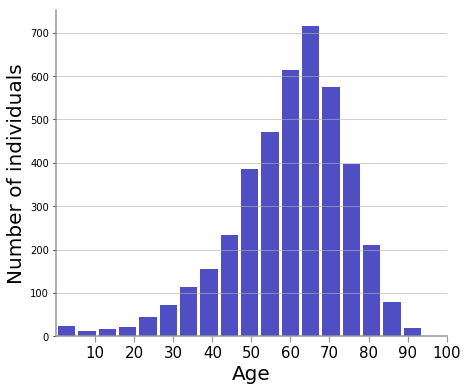

In [15]:
# plotting age distribution of Bolton cohort
import matplotlib.pyplot as plt
scale = 1.2

plt.clf()
plt.close('all')
f, ax1 = plt.subplots(1, 1, figsize=(7,6))
font = {'weight' : 'normal','size'   : 16}
matplotlib.rc('font', **font)
f.subplots_adjust(hspace=0.4)
 
axisfont = 15

n, bins, patches = plt.hist(x=list_of_Bolton_ages , bins='doane', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Age', fontsize = 20)
plt.ylabel('Number of individuals', fontsize = 20)

x_major_ticks = [10,20,30,40,50,60,70,80,90,100]
x_major_tick_labels = ["10","20","30","40","50","60","70","80","90","100"]
ax1.set_xticks(x_major_ticks)
ax1.set_xticklabels(x_major_tick_labels, fontsize = axisfont)
ax1.xaxis.set_tick_params(width=scale, color = grey3, length = 6)

ax1.set_xlim(0,100)
#Only show the required axis lines
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

for axis in ['bottom','left']:
    ax1.spines[axis].set_linewidth(1.5)

for axis in ['bottom','left']:
    ax1.spines[axis].set_color(grey3)
    
# plt.savefig('Bolton_age_distribution.pdf', bbox_inches='tight')

## Age dependence of synonymous VAF spectrum in healthy blood 

In [14]:
# Setting parameters

Razavitotal = 47
Boltontotal = 4160

Razavi_panel_size = 1282206
Bolton_v3panel_size = 896665  # bp
Bolton_v5panel_size = 1016478  # bp
Bolton_v6panel_size = 1139322  # bp
Bolton_panel_size = Bolton_v6panel_size  # bp
Illumina_myeloid_panel = 141*1000 # bp

# use the mutation rate scaled from the Illumina myeloid panel 
# targets coding regions and is most likely to have more similar mutation rates per bp to the MSK-IMPACT panels
# than averaging over the whole genome (as in Lee Six et al.) 
syn_mu_on_Illumina_myeloid_panel =  8.5*10**-5  # calculated by exluding common germline base changes in 1000 genomes
nonsyn_mu_on_Illumina_myeloid_panel =  1.9*10**-4  # calculated by exluding common germline base changes in 1000 genomes
nonsynonymous_mu_per_bp = nonsyn_mu_on_Illumina_myeloid_panel/Illumina_myeloid_panel
synonymous_mu_per_bp = syn_mu_on_Illumina_myeloid_panel/Illumina_myeloid_panel
mu_per_bp = (nonsyn_mu_on_Illumina_myeloid_panel+syn_mu_on_Illumina_myeloid_panel)/Illumina_myeloid_panel
syn_total_mut_rate_ratio = synonymous_mu_per_bp/mu_per_bp
print('nonsynonymous_mu_per_bp', nonsynonymous_mu_per_bp)
print('synonymous_mu_per_bp', synonymous_mu_per_bp)
print('mu_per_bp',mu_per_bp)
print('ratio of synonymous mutation rate to total SNV mutation rate on Illumina panel', syn_total_mut_rate_ratio)


Razavi_synonymous_mu = synonymous_mu_per_bp*Razavi_panel_size
Bolton_v3panel_syn_mu = synonymous_mu_per_bp*Bolton_v3panel_size
Bolton_v5panel_syn_mu = synonymous_mu_per_bp*Bolton_v5panel_size
Bolton_v6panel_syn_mu = synonymous_mu_per_bp*Bolton_v6panel_size
Bolton_v3panel_non_syn_mu = nonsynonymous_mu_per_bp*Bolton_v3panel_size
Bolton_v5panel_non_syn_mu = nonsynonymous_mu_per_bp*Bolton_v5panel_size
Bolton_v6panel_non_syn_mu = nonsynonymous_mu_per_bp*Bolton_v6panel_size
Razavi_nonsynonymous_mu = nonsynonymous_mu_per_bp*Razavi_panel_size
Razavi_synonymous_mu = synonymous_mu_per_bp*Razavi_panel_size
Bolton_synonymous_mu = Bolton_v6panel_syn_mu
print('Bolton_synonymous_mu', Bolton_synonymous_mu)
print('Razavi_synonymous_mu', Razavi_synonymous_mu)
Bolton_nonsynonymous_mu = Bolton_v6panel_non_syn_mu
print('Razavi_nonsynonymous_mu', Razavi_nonsynonymous_mu)
print('Bolton_nonsynonymous_mu', Bolton_nonsynonymous_mu)
# Bolton_468panel_mu = mu_per_bp*Bolton_panel_size
# print('Bolton_468panel_mu', Bolton_468panel_mu)
Young_synonymous_mu = 8.50E-05
Acuna_Hidalgo_synonymous_mu = 2.73E-06

# This estimate is from Lee Six et al.
# NB:  if a mutation had mutant reads in greater than 120 out of 140 clonal
# colonies we considered it as germline
# Mutations that fell within 10 base pairs of each other or within 10 base pairs of
# indels were removed.
number_of_mutation_across_haploid_genome_per_cell_doubling = 1.84
# mappable genome size of GRCh37
haploid_genome_size = 2864785220

# assuming mutations are evenly distributed across coding versus non coding regions
# haploid mutation rates
Razavi_dev_per_doubling_synonymous_mu_LeeSix = number_of_mutation_across_haploid_genome_per_cell_doubling*Razavi_panel_size/haploid_genome_size*syn_total_mut_rate_ratio
Bolton_dev_per_doubling_synonymous_mu_LeeSix = number_of_mutation_across_haploid_genome_per_cell_doubling*Bolton_panel_size/haploid_genome_size*syn_total_mut_rate_ratio
print('Razavi_dev_per_doubling_synonymous_mu_LeeSix', Razavi_dev_per_doubling_synonymous_mu_LeeSix)
print('Bolton_dev_per_doubling_synonymous_mu_LeeSix', Bolton_dev_per_doubling_synonymous_mu_LeeSix)

Bolton_dev_per_doubling_nonsynonymous_mu_LeeSix = number_of_mutation_across_haploid_genome_per_cell_doubling*Bolton_panel_size/haploid_genome_size*(1-syn_total_mut_rate_ratio)
print('Bolton_dev_per_doubling_nonsynonymous_mu_LeeSix', Bolton_dev_per_doubling_nonsynonymous_mu_LeeSix)

nonsynonymous_mu_per_bp 1.3475177304964539e-09
synonymous_mu_per_bp 6.028368794326241e-10
mu_per_bp 1.950354609929078e-09
ratio of synonymous mutation rate to total SNV mutation rate on Illumina panel 0.3090909090909091
Bolton_synonymous_mu 0.0006868253191489362
Razavi_synonymous_mu 0.0007729610638297872
Razavi_nonsynonymous_mu 0.001727795319148936
Bolton_nonsynonymous_mu 0.0015352565957446808
Razavi_dev_per_doubling_synonymous_mu_LeeSix 0.0002545480604841104
Bolton_dev_per_doubling_synonymous_mu_LeeSix 0.00022618222451531
Bolton_dev_per_doubling_nonsynonymous_mu_LeeSix 0.0005055837959753989


In [15]:
# consider the lower quartile versus upper quartile age groups
n_patient_lower_quartile=0
n_patient_upper_quartile=0
n_patient_all=0
list_of_syn_VAF_lower_quartile=[]
list_of_syn_VAF_upper_quartile=[]
list_of_syn_VAF_all=[]
list_of_ages_lower_quartile=[]
list_of_ages_upper_quartile=[]

percentile_lower_quartile=np.percentile(list_of_Bolton_ages,[25])[0]
print('lower percentile', percentile_lower_quartile)
percentile_upper_quartile=np.percentile(list_of_Bolton_ages,[75])[0]
print('upper percentile', percentile_upper_quartile)

for patient_id, age in Untreated_patients_dictionary.items():
    
    n_patient_all = n_patient_all + 1

    if patient_id in Bolton_syn_SNV_individual_dictionary.keys():
        list_vaf=Bolton_syn_SNV_individual_dictionary[patient_id]
    else:
        list_vaf=[]
        
    for i in list_vaf:
        list_of_syn_VAF_all.append(i)

    if age < percentile_lower_quartile:
        n_patient_lower_quartile = n_patient_lower_quartile + 1
        list_of_ages_lower_quartile.append(age)
#         if list_vaf !=[]:
        for i in list_vaf:
            list_of_syn_VAF_lower_quartile.append(i)

    if percentile_upper_quartile < age:
        n_patient_upper_quartile = n_patient_upper_quartile + 1
        list_of_ages_upper_quartile.append(age)
        for i in list_vaf:
            list_of_syn_VAF_upper_quartile.append(i)
  
    
        
color_younger = blue4
color_older = blue5

print('no of patients in younger age group:', n_patient_lower_quartile, 'no of patients in older age group:', n_patient_upper_quartile)
print('no of variants in younger age group:', len(list_of_syn_VAF_lower_quartile), 'no of variants in older age group:', len(list_of_syn_VAF_upper_quartile))
print('no. of all patients', n_patient_all)

lower percentile 51.802190782500006
upper percentile 69.4832305875
no of patients in younger age group: 1040 no of patients in older age group: 1040
no of variants in younger age group: 26 no of variants in older age group: 112
no. of all patients 4160


widths <class 'numpy.ndarray'>
widths_holder <class 'numpy.ndarray'>
log_hist_for_plot is [ 3.70805148  2.9574934   2.16903604  1.14738479 -0.13354906]
errors is [(0.06775668396174117, 0.10020301504124474, 0.15247699682656402, 0.2687978542092353, 0.5927836007167084), (0.06345560206235046, 0.0910705314779725, 0.13227428950904452, 0.2116394403692865, 0.3696400494024986)]
min(log_hist_for_plot) -0.13354905714935508
max(log_hist_for_plot) 3.708051483982245
widths <class 'numpy.ndarray'>
widths_holder <class 'numpy.ndarray'>
log_hist_for_plot is [ 2.90140393  2.04120266  1.43506686 -0.35669261        -inf]
errors is [(0.21830046692588212, 0.3588363417595517, 0.5246681416422596, 2.302585092994046, nan), (0.179079753772601, 0.26352616195522716, 0.34234658484830516, 0.6931471805599454, nan)]
min(log_hist_for_plot) -inf
max(log_hist_for_plot) 2.901403929557917
widths <class 'numpy.ndarray'>
widths_holder <class 'numpy.ndarray'>
log_hist_for_plot is [4.36180626 3.61359931 2.90140393 1.94589248 1

C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:409: RuntimeWarning: divide by zero encountered in log
C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log
C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log
C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log
C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


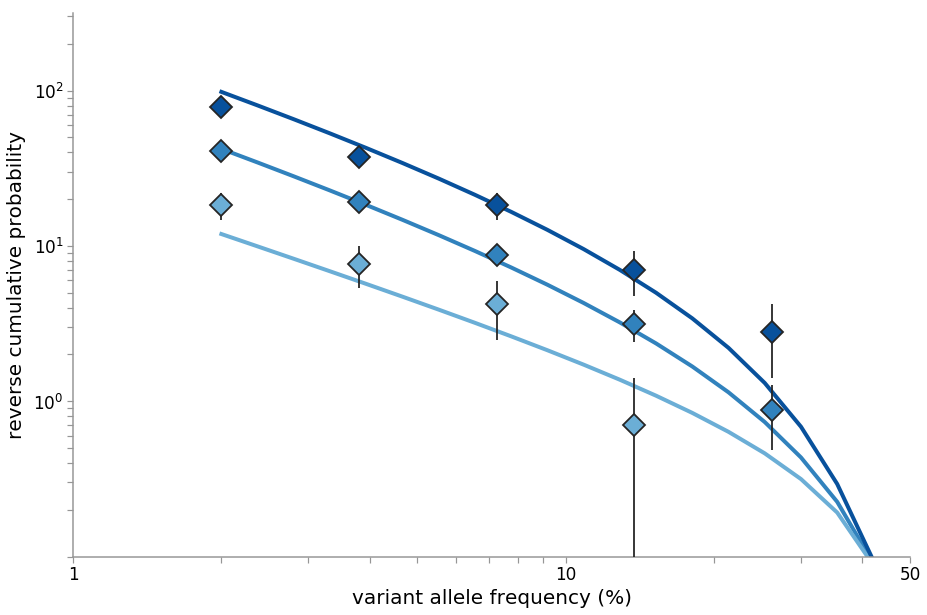

In [23]:
plt.clf()
plt.close('all')
f, ax1 = plt.subplots(1, 1, figsize=(15,10))
font = {'weight' : 'normal','size'   : 16}
matplotlib.rc('font', **font)
f.subplots_adjust(hspace=0.4)

import timeit

start = timeit.default_timer()


#linear binning : same bins and limits in the same simulation with same alpha
Bolton_synonymous_bins_above_lmin = 6
lmax_Bolton=np.log(0.499)
lmin_Bolton=np.log(2/100)

fmin=np.exp(lmin_Bolton)
fmax=np.exp(lmax_Bolton)

binsize = (lmax_Bolton - lmin_Bolton)/(Bolton_synonymous_bins_above_lmin-1)

linear_VAF=np.linspace(fmin, fmax, 30)
# log_VAF=np.linspace(np.log(1.5/100), lmax_Bolton, 30)
log_VAF=np.linspace(np.log(2/100), lmax_Bolton, 20)
 
scale=1.2
    
plot_log_hist_data_rcumulative_rescaled_by_syn_rate_not_divided_by_binsize_shift_to_left_no_cap(list_of_syn_VAF_all, n_patient_all, Bolton_synonymous_mu,\
                                                            Bolton_synonymous_bins_above_lmin, lmin_Bolton, lmax_Bolton, 'all',\
                                                           'D', 10, blue4, scale)
plot_log_hist_data_rcumulative_rescaled_by_syn_rate_not_divided_by_binsize_shift_to_left_no_cap(list_of_syn_VAF_lower_quartile, n_patient_lower_quartile, Bolton_synonymous_mu,\
                                                            Bolton_synonymous_bins_above_lmin, lmin_Bolton, lmax_Bolton, 'lower quartile',\
                                                           'D', 10, blue3, scale)

plot_log_hist_data_rcumulative_rescaled_by_syn_rate_not_divided_by_binsize_shift_to_left_no_cap(list_of_syn_VAF_upper_quartile, n_patient_upper_quartile, Bolton_synonymous_mu,\
                                                            Bolton_synonymous_bins_above_lmin, lmin_Bolton, lmax_Bolton, 'upper quartile',\
                                                           'D', 10, blue5, scale)


# ax1.axvline(x = lmax_Bolton, color =grey4, linestyle='--')
# ax1.axvline(x = lmin_Bolton, color =grey4, linestyle='--')
ax1.set_ylim(np.log(10**-1), np.log(10**2.5))
ax1.set_xlim(np.log(0.01), np.log(0.5))

def hitchhiker_prediction_overall(l, params, N_tau, s_lower, s_upper, u_dev, u_neu, list_of_control_ages):
        
    summed_result = linProbtheory_actual_ages_hitch_DFE(l, params, N_tau, s_lower, s_upper, list_of_control_ages)+\
    linProbtheory_ages_dev(l, u_dev, u_neu)
    
    return summed_result

def rcum_hitchhiker_prediction_overall(l,lmax, params, N_tau, s_lower, s_upper, u_dev, u_neu, list_of_Bolton_ages):

    result = integrate.quad(lambda l_var: hitchhiker_prediction_overall(l_var, params, N_tau, s_lower, s_upper, \
                                                                        u_dev, u_neu, list_of_Bolton_ages), l, lmax)[0]

    return result

best_fit_u_shift_to_left = 2.531249999999855e-05
print('best_fit_u_shift_to_left', best_fit_u_shift_to_left)

s_max_inferred=1
density_hitchhiker_bestfit_combined_rcumulative_log=[]
for l in log_VAF:

    tmp=np.log(rcum_hitchhiker_prediction_overall(l, lmax_Bolton, [p_inferred, q_inferred, best_fit_u_shift_to_left], N_tau_blood, s_tolerance, s_max_inferred,\
                                                  Bolton_dev_per_doubling_synonymous_mu_LeeSix, Bolton_synonymous_mu, list_of_Bolton_ages)) 
    density_hitchhiker_bestfit_combined_rcumulative_log.append(tmp)
    print('tmp:',tmp, 'at l:', l)
    stop = timeit.default_timer()
    print('Time: ', stop - start)
    start=stop

print('density_hitchhiker_bestfit_combined_rcumulative_log',density_hitchhiker_bestfit_combined_rcumulative_log)
ax1.plot(log_VAF, density_hitchhiker_bestfit_combined_rcumulative_log, color=blue4, lw=4, zorder=2, label='')

density_hitchhiker_bestfit_lower_quartile_rcumulative_log=[]
for l in log_VAF:
    tmp=np.log(rcum_hitchhiker_prediction_overall(l, lmax_Bolton , [p_inferred, q_inferred, best_fit_u_shift_to_left], N_tau_blood, s_tolerance, s_max_inferred, \
                                                  Bolton_dev_per_doubling_synonymous_mu_LeeSix, Bolton_synonymous_mu, list_of_ages_lower_quartile)) 
    density_hitchhiker_bestfit_lower_quartile_rcumulative_log.append(tmp)
    print('tmp:',tmp, 'at l:', l)
    stop = timeit.default_timer()
    print('Time: ', stop - start)
    start=stop
    
print('density_hitchhiker_bestfit_lower_quartile_rcumulative_log',density_hitchhiker_bestfit_lower_quartile_rcumulative_log)
ax1.plot(log_VAF, density_hitchhiker_bestfit_lower_quartile_rcumulative_log, color=blue3, lw=4, zorder=2, label='')


density_hitchhiker_bestfit_upper_quartile_rcumulative_log=[]
for l in log_VAF:
    tmp=np.log(rcum_hitchhiker_prediction_overall(l, lmax_Bolton , [p_inferred, q_inferred, best_fit_u_shift_to_left], N_tau_blood, s_tolerance, s_max_inferred, \
                                                  Bolton_dev_per_doubling_synonymous_mu_LeeSix, Bolton_synonymous_mu, list_of_ages_upper_quartile)) 
    density_hitchhiker_bestfit_upper_quartile_rcumulative_log.append(tmp)
    print('tmp:',tmp, 'at l:', l)
    stop = timeit.default_timer()
    print('Time: ', stop - start)
    start=stop
    
print('density_hitchhiker_bestfit_upper_quartile_rcumulative_log',density_hitchhiker_bestfit_upper_quartile_rcumulative_log)
ax1.plot(log_VAF, density_hitchhiker_bestfit_upper_quartile_rcumulative_log, color=blue5, lw=4, zorder=2, label='')


# plt.savefig('Bolton_4160_untreated_patients_blood_age_groups_data_with_prediction_lower_quartile_vs_upper_quartile.pdf',bbox_inches='tight')


### Stored results 

In [20]:
log_VAF=np.linspace(np.log(2/100), lmax_Bolton, 20)

density_hitchhiker_bestfit_lower_quartile_rcumulative_log = [2.4782195858867677, 2.2950539878017255, 2.1109425989220796, 1.9255623340436452, 1.7385125305809606, 1.549295045601308, 1.3572869645318002, 1.1617023104900883, 0.9615369315689014, 0.7554868863689379, 0.541823472640069, 0.31819415705002485, 0.08128967697603377, -0.17374736693677353, -0.4544581031018167, -0.7734863277635821, -1.154544473277525, -1.6508762443728107, -2.432383205352135, -float('inf')]

density_hitchhiker_bestfit_upper_quartile_rcumulative_log = [4.585649857332419, 4.384770996101111, 4.17962433947147, 3.969519263168433, 3.75361647791466, 3.5308842669433105, 3.3000377887820442, 3.0594533045848014, 2.8070441768492653, 2.540076608899139, 2.2548870752338064, 1.9464339614791228, 1.6075569936737881, 1.22769855159059, 0.7905913355700733, 0.26991885424612144, -0.37866552063000886, -1.2276216325039528, -2.3649101873671916, -float('inf')]

density_hitchhiker_bestfit_combined_rcumulative_log = [3.7407893275719335, 3.538852838030008, 3.3332913093791205, 3.123553188857905, 2.9089706190872713, 2.688726639062398, 2.4618106462079306, 2.2269567182394643, 1.982556480130726, 1.726532993232403, 1.456152945471782, 1.1677388760877088, 0.856212047021711, 0.5143375607238836, 0.1314206022610395, -0.30906559491196367, -0.8341186580793628, -1.492153872980906, -2.408468217087784, -float('inf')]


## Age dependence of synonymous VAF spectrum in healthy oesophagus

In [21]:
# donor information
age1=21.5
age2=25.5
age3=37.5
age4=45.5
age5=49.5
age6=53.5
age7=57.5
age8=69.5
age9=73.5
Martincorena_donor_ages = [age1, age2, age3, age4, age5, age6, age7, age8, age9]
Martincorena_donor_ages_younger = [age1, age2, age3]
Martincorena_donor_ages_older = [age7, age8, age9]

n_sample=844
n_sample_1=84
n_sample_2=93
n_sample_3=96
n_sample_4=94
n_sample_5=95
n_sample_6=98
n_sample_7=95
n_sample_8=95
n_sample_9=94

num_patient=9

list_of_n_samples_per_person=[n_sample_1, n_sample_2, n_sample_3, n_sample_4, n_sample_5, n_sample_6, n_sample_7, n_sample_8, n_sample_9]


In [22]:
# Setting parameters

# mappable genome size of GRCh37
haploid_genome_size = 2864785220

u_estimated_per_bp=35/(haploid_genome_size)/2    # haploid per year
print('annual haploid mutation rate per bp is', u_estimated_per_bp)
print('compared to annual haploid mutation rate per bp in healthy blood', 1.950354609929078e-09)
correction_factor_to_oesophagus = u_estimated_per_bp/1.950354609929078e-09
print('correction_factor_to_oesophagus', correction_factor_to_oesophagus)

oesophagus_target_size=330*10**3 # coding regions of the panel
u_martincorena_panel=u_estimated_per_bp*oesophagus_target_size   # haploid per year, estimated from literature
ratio_syn_total = 0.3090909090909091 # same as Illumina panel
syn_total_mut_rate_ratio = ratio_syn_total
oesophagus_nonsyn_mut_rate_per_bp = u_estimated_per_bp*(1-ratio_syn_total)
oesophagus_syn_mut_rate_per_bp = u_estimated_per_bp*(ratio_syn_total)
Martincorena_synonymous_mu = u_martincorena_panel*ratio_syn_total
u_oes_syn = Martincorena_synonymous_mu
print('estimated synonymous annual haploid rates across panel:', Martincorena_synonymous_mu)
Martincorena_nonsynonymous_mu = u_martincorena_panel*(1-ratio_syn_total)
u_oes_nonsyn = Martincorena_nonsynonymous_mu
print('estimated nonsynonymous annual haploid rates: across panel', Martincorena_nonsynonymous_mu)

# This estimate is from Lee Six et al.
# NB:  if a mutation had mutant reads in greater than 120 out of 140 clonal
# colonies we considered it as germline
# Mutations that fell within 10 base pairs of each other or within 10 base pairs of
# indels were removed.
number_of_mutation_across_haploid_genome_per_cell_doubling_in_blood = 1.84
number_of_mutation_across_haploid_genome_per_cell_doubling_in_oesophagus = correction_factor_to_oesophagus*number_of_mutation_across_haploid_genome_per_cell_doubling_in_blood
oesophagus_dev_synonymous_mu_LeeSix = oesophagus_target_size/haploid_genome_size*number_of_mutation_across_haploid_genome_per_cell_doubling_in_oesophagus*ratio_syn_total
print('oesophagus_dev_synonymous_mu_LeeSix', oesophagus_dev_synonymous_mu_LeeSix)



annual haploid mutation rate per bp is 6.108660390254317e-09
compared to annual haploid mutation rate per bp in healthy blood 1.950354609929078e-09
correction_factor_to_oesophagus 3.1320767819122137
estimated synonymous annual haploid rates across panel: 0.0006230833598059403
estimated nonsynonymous annual haploid rates: across panel 0.0013927745689779844


In [23]:
# Import merged data set

Martincorena_oesophagus_data_merged='Martincorena_oesophagus_VAF_merged.csv'

trimmed_fmin=0.01 # trimming data below 1 % VAF
trimmed_fmax=0.5

num_syn_mut=0
num_nonsyn_mut=0
num_nonsense_mut=0

Patient_ID1='PD36806'
Patient_ID2='PD36712'
Patient_ID3='PD30272'
Patient_ID4='PD30986'
Patient_ID5='PD30987'
Patient_ID6='PD30274'
Patient_ID7='PD30988'
Patient_ID8='PD30273'
Patient_ID9='PD31182'

donor_age_dictionary = {}
donor_age_dictionary[Patient_ID1] = age1
donor_age_dictionary[Patient_ID2] = age2
donor_age_dictionary[Patient_ID3] = age3
donor_age_dictionary[Patient_ID4] = age4
donor_age_dictionary[Patient_ID5] = age5
donor_age_dictionary[Patient_ID6] = age6
donor_age_dictionary[Patient_ID7] = age7
donor_age_dictionary[Patient_ID8] = age8
donor_age_dictionary[Patient_ID9] = age9


syn_SNV_VAF_by_donor = {}
synonymous_call_been_collapsed = 0


with open(Martincorena_oesophagus_data_merged) as data:
    reader = csv.DictReader(data,delimiter=',')
#     next(reader, None)   #skips header
    for row in reader:
        
        donor_ID=str(row['donor'])
        merge_status=str(row['merged'])
        vaf=float(row['sumvaf'])
        ref_base = str(row['ref'])
        mut_base = str(row['mut'])
        gene=str(row['gene'])
        mutation_impact=str(row['impact'])
        sample_id = str(row['pid'])


  #                 Synonymous variants

        if mutation_impact=='Synonymous':
        
            num_syn_mut=num_syn_mut+1
        
            if donor_ID in syn_SNV_VAF_by_donor.keys():
                tmp2 = syn_SNV_VAF_by_donor[donor_ID]
                tmp2.append(vaf)
                syn_SNV_VAF_by_donor[donor_ID] = tmp2
            else:
#                 print(vaf)
                syn_SNV_VAF_by_donor[donor_ID] = [vaf]
                
            if merge_status !='' and merge_status !='too_far':
                synonymous_call_been_collapsed = synonymous_call_been_collapsed + 1
                count_comma=merge_status.count(';')
#                 merged_size_synonymous.append(count_comma+1)
  
    


In [24]:
# consider youngest 3 and oldest 3 donors

n_patient_younger=0
n_patient_youngest_1 = 0
n_patient_youngest_2 = 0
n_patient_older=0
n_patient_all=0
list_of_syn_VAF_younger=[]
list_of_syn_VAF_youngest_1=[]
list_of_syn_VAF_youngest_2=[]
list_of_syn_VAF_older=[]
list_of_syn_VAF_all=[]
list_of_ages_younger=[]
list_of_ages_youngest_1=[]
list_of_ages_youngest_2=[]
list_of_ages_older=[]

n_sample_younger = n_sample_1+n_sample_2+n_sample_3
n_sample_older = n_sample_7+n_sample_8+n_sample_9
n_sample_youngest_2 = n_sample_1+n_sample_2
    
for donor_ID, age in donor_age_dictionary.items():
    
    list_vaf = syn_SNV_VAF_by_donor[donor_ID]
    
    for i in list_vaf:
        list_of_syn_VAF_all.append(i)
        
    if donor_ID in ['PD36806']:
        n_patient_youngest_1 = n_patient_youngest_1 + 1
        list_of_ages_youngest_1.append(age)
#         if list_vaf !=[]:
        for i in list_vaf:
            list_of_syn_VAF_youngest_1.append(i)
        
    if donor_ID in ['PD36806', 'PD36712']:
        n_patient_youngest_2 = n_patient_youngest_2 + 1
        list_of_ages_youngest_2.append(age)
#         if list_vaf !=[]:
        for i in list_vaf:
            list_of_syn_VAF_youngest_2.append(i)

    if donor_ID in ['PD36806', 'PD36712','PD30272']:
#         print('donor_ID', donor_ID)
        
#         print('len(list_vaf)', len(list_vaf))
        n_patient_younger = n_patient_younger + 1
        list_of_ages_younger.append(age)
#         if list_vaf !=[]:
        for i in list_vaf:
            list_of_syn_VAF_younger.append(i)

    if donor_ID in ['PD30988','PD30273','PD31182']:
        
        n_patient_older = n_patient_older + 1
        list_of_ages_older.append(age)
        for i in list_vaf:
            list_of_syn_VAF_older.append(i)
  
    
        
color_younger = blue4
color_older = blue5
print('no of patients in youngest 1 :', n_patient_youngest_1, 'no of variants:', len(list_of_syn_VAF_youngest_1))
print('no of patients in youngest 2 :', n_patient_youngest_2, 'no of variants:', len(list_of_syn_VAF_youngest_2))
print('no of patients in youngest 3 age group:', n_patient_younger, 'no of patients in oldest 3 age group:', n_patient_older)
print('no of variants in youngest 3 age group:', len(list_of_syn_VAF_younger), 'no of variants in oldest 3 age group:', len(list_of_syn_VAF_older))
print('no. of all patients', n_patient_all)
print('total number of synonymous variants', len(list_of_syn_VAF_all))

no of patients in youngest 1 : 1 no of variants: 23
no of patients in youngest 2 : 2 no of variants: 63
no of patients in youngest 3 age group: 3 no of patients in oldest 3 age group: 3
no of variants in youngest 3 age group: 120 no of variants in oldest 3 age group: 270
no. of all patients 0
total number of synonymous variants 603


widths <class 'numpy.ndarray'>
widths_holder <class 'numpy.ndarray'>
log_hist_for_plot is [5.69253376 5.2377976  4.83233249 4.3315572  3.86155357 3.28173508
 2.5885879  1.04814286       -inf]
errors is [(0.05827959099070057, 0.07371856154742673, 0.09106192719714556, 0.11856216283151255, 0.15247699682656402, 0.2094653219063658, 0.3109660415933355, 0.8612115025164907, nan), (0.0550693153604529, 0.06865525959088092, 0.08345732781192527, 0.10598338062465196, 0.13227428950904452, 0.17309767773549112, 0.23685806943961385, 0.4557463944083262, nan)]
min(log_hist_for_plot) -inf
max(log_hist_for_plot) 5.6925337569194765
widths <class 'numpy.ndarray'>
widths_holder <class 'numpy.ndarray'>
log_hist_for_plot is [5.10356296 4.16925372 3.27543585 2.68764918 1.77135845       -inf
       -inf       -inf       -inf]
errors is [(0.1434439266671701, 0.2397821029348699, 0.4054651081081646, 0.5927836007167082, 1.227947177299516, nan, nan, nan, nan), (0.12542542116449074, 0.19326208729997685, 0.2876820724517

C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:409: RuntimeWarning: divide by zero encountered in log
C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log
C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log
C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log
C:\Users\chickchick\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


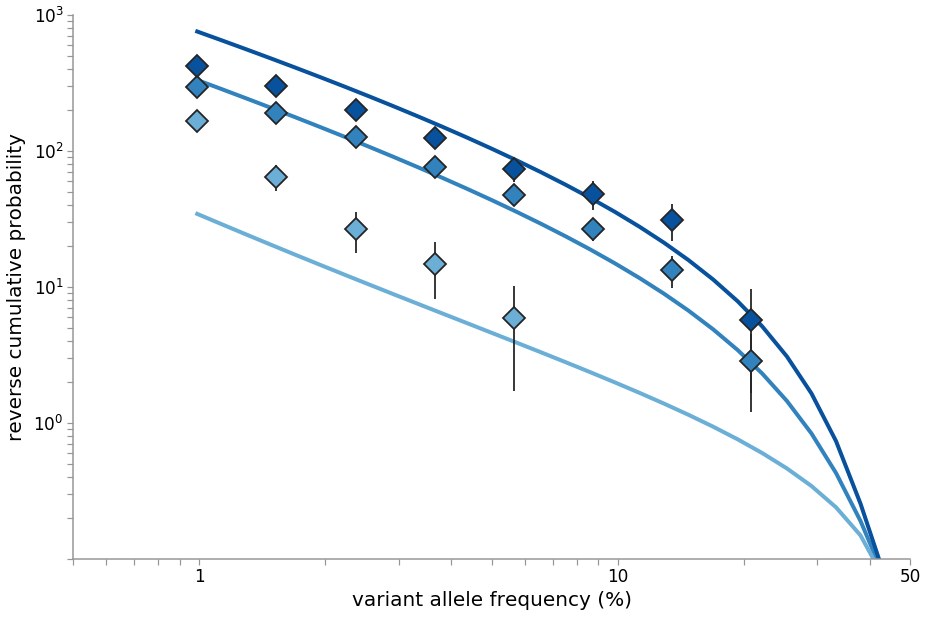

In [28]:
plt.clf()
plt.close('all')
f, ax1 = plt.subplots(1, 1, figsize=(15,10))
font = {'weight' : 'normal','size'   : 16}
matplotlib.rc('font', **font)
f.subplots_adjust(hspace=0.4)

import timeit

start = timeit.default_timer()


#linear binning : same bins and limits in the same simulation with same alpha
Martincorena_synonymous_bins_above_lmin = 10
lmax_Martincorena=np.log(0.499)
lmin_Martincorena=np.log(0.99/100)

fmin=np.exp(lmin_Martincorena)
fmax=np.exp(lmax_Martincorena)

binsize = (lmax_Martincorena - lmin_Martincorena)/(Martincorena_synonymous_bins_above_lmin-1)

linear_VAF=np.linspace(fmin, fmax, 30)
log_VAF=np.linspace(lmin_Martincorena, lmax_Martincorena, 30)
 
scale=1.2
    
plot_log_hist_data_rcumulative_rescaled_by_syn_rate_not_divided_by_binsize_shift_to_left_no_cap(list_of_syn_VAF_all, n_sample, Martincorena_synonymous_mu,\
                                                            Martincorena_synonymous_bins_above_lmin, lmin_Martincorena, lmax_Martincorena, 'all',\
                                                           'D', 10, blue4, scale)

plot_log_hist_data_rcumulative_rescaled_by_syn_rate_not_divided_by_binsize_shift_to_left_no_cap(list_of_syn_VAF_younger, n_sample_younger, Martincorena_synonymous_mu,\
                                                            Martincorena_synonymous_bins_above_lmin, lmin_Martincorena, lmax_Martincorena, 'younger',\
                                                           'D', 10, blue3, scale)

plot_log_hist_data_rcumulative_rescaled_by_syn_rate_not_divided_by_binsize_shift_to_left_no_cap(list_of_syn_VAF_older, n_sample_older, Martincorena_synonymous_mu,\
                                                            Martincorena_synonymous_bins_above_lmin, lmin_Martincorena, lmax_Martincorena, 'older',\
                                                           'D', 10, blue5, scale)




# ax1.axvline(x = lmax_Martincorena, color =grey4, linestyle='--')
# ax1.axvline(x = lmin_Martincorena, color =grey4, linestyle='--')
ax1.set_ylim(np.log(10**-1), np.log(10**3))
ax1.set_xlim(np.log(0.005), np.log(0.5))


def hitchhiker_prediction_overall_for_oesophagus_samples(l, params, N_tau, s_lower, s_upper, u_dev, u_neu, Martincorena_donor_ages, list_of_n_samples_per_person, n_sample):
        
    summed_result = linProbtheory_actual_ages_hitch_DFE_for_oesophagus_samples(l, params, N_tau, s_lower, s_upper, Martincorena_donor_ages, list_of_n_samples_per_person, n_sample)+\
    linProbtheory_ages_dev(l, u_dev, u_neu)
    
    return summed_result

def rcum_hitchhiker_prediction_overall_for_oesophagus_samples(l, lmax, params, N_tau, s_lower, s_upper, u_dev, u_neu, Martincorena_donor_ages, list_of_n_samples_per_person, n_sample):

    result = integrate.quad(lambda l_var: hitchhiker_prediction_overall_for_oesophagus_samples(l_var, params, N_tau, s_lower, s_upper, \
                                                                        u_dev, u_neu, Martincorena_donor_ages, list_of_n_samples_per_person, n_sample), l, lmax)[0]

    return result



s_max_inferred=1
density_hitchhiker_bestfit_combined_rcumulative_log=[]
for l in log_VAF:
    tmp=np.log(rcum_hitchhiker_prediction_overall_for_oesophagus_samples(l, lmax_Martincorena, [p_inferred, q_inferred, best_fit_haploid_driver_rate_oesophagus], N_tau_oesophagus, s_tolerance, s_max_inferred,\
                                                  Martincorena_dev_per_doubling_synonymous_mu_LeeSix, Martincorena_synonymous_mu, Martincorena_donor_ages, list_of_n_samples_per_person, n_sample)) 
    density_hitchhiker_bestfit_combined_rcumulative_log.append(tmp)
    print('tmp:',tmp, 'at l:', l)
    stop = timeit.default_timer()
    print('Time: ', stop - start)
    start=stop

print('density_hitchhiker_bestfit_combined_rcumulative_log',density_hitchhiker_bestfit_combined_rcumulative_log)
ax1.plot(log_VAF, density_hitchhiker_bestfit_combined_rcumulative_log, color=blue4, lw=4, zorder=2, label='')

s_max_inferred=1
density_hitchhiker_bestfit_younger_rcumulative_log=[]
for l in log_VAF:
    tmp=np.log(rcum_hitchhiker_prediction_overall_for_oesophagus_samples(l, lmax_Martincorena, [p_inferred, q_inferred, best_fit_haploid_driver_rate_oesophagus], N_tau_oesophagus, s_tolerance, s_max_inferred,\
                                                  Martincorena_dev_per_doubling_synonymous_mu_LeeSix, Martincorena_synonymous_mu, Martincorena_donor_ages[0:3], list_of_n_samples_per_person[0:3], sum(list_of_n_samples_per_person[0:3]) )) 
    density_hitchhiker_bestfit_younger_rcumulative_log.append(tmp)
    print('tmp:',tmp, 'at l:', l)
    stop = timeit.default_timer()
    print('Time: ', stop - start)
    start=stop

print('density_hitchhiker_bestfit_younger_rcumulative_log', density_hitchhiker_bestfit_younger_rcumulative_log)
ax1.plot(log_VAF, density_hitchhiker_bestfit_younger_rcumulative_log, color=blue3, lw=4, zorder=2, label='')

s_max_inferred=1
density_hitchhiker_bestfit_older_rcumulative_log=[]
for l in log_VAF:
    tmp=np.log(rcum_hitchhiker_prediction_overall_for_oesophagus_samples(l, lmax_Martincorena, [p_inferred, q_inferred, best_fit_haploid_driver_rate_oesophagus], N_tau_oesophagus, s_tolerance, s_max_inferred,\
                                                  Martincorena_dev_per_doubling_synonymous_mu_LeeSix, Martincorena_synonymous_mu, Martincorena_donor_ages[6:], list_of_n_samples_per_person[6:], sum(list_of_n_samples_per_person[6:]) )) 
    density_hitchhiker_bestfit_older_rcumulative_log.append(tmp)
    print('tmp:',tmp, 'at l:', l)
    stop = timeit.default_timer()
    print('Time: ', stop - start)
    start=stop

print('density_hitchhiker_bestfit_older_rcumulative_log', density_hitchhiker_bestfit_older_rcumulative_log)
ax1.plot(log_VAF, density_hitchhiker_bestfit_older_rcumulative_log, color=blue5, lw=4, zorder=2, label='')


# plt.savefig('Martincorena_age_groups_youngest_3_vs_oldest_3.pdf',bbox_inches='tight')


In [25]:
# Stored reults for oesophagus: youngest 3 donors versus oldest 3

density_hitchhiker_bestfit_combined_rcumulative_log = [5.804527033715235, 5.649534986160629, 5.4925951108546185, 5.333563431674125, 5.172271202968244, 5.008522229216765, 4.842087402562057, 4.672696776380098, 4.500029468040535, 4.3237014221522525, 4.143250656361486, 3.958119366081015, 3.767631582772312, 3.570964571556969, 3.3671118155151367, 3.154833016845605, 2.932585674210765, 2.6984287941197245, 2.449884092263735, 2.1837312205368096, 1.8956990185948124, 1.5799907637306914, 1.2285424287288333, 0.8298588203668954, 0.3672504777286304, -0.1833689859193627, -0.8535852501777704, -1.6689298850925485, -2.653953960752489, -float('inf')]

density_hitchhiker_bestfit_older_rcumulative_log = [6.626257878168078, 6.476225551482682, 6.324209937173641, 6.170026925506196, 6.013468602680116, 5.854300572514973, 5.692256502739875, 5.527030082780306, 5.358264365820419, 5.185538206253947, 5.008349241598165, 4.826092720504572, 4.63803479903201, 4.443278368123976, 4.240718994586136, 4.028985346168867, 3.8063570180138733, 3.570647050762645, 3.319028741508379, 3.0477725953826744, 2.7518346982568422, 2.424191626167029, 2.0547264268395735, 1.6282879105646573, 1.1211901962420106, 0.49491745384419744, -0.3129106389661192, -1.3765662589751955, -2.6252635166309517, -float('inf')]

density_hitchhiker_bestfit_younger_rcumulative_log = [3.536127706614278, 3.360487388956948, 3.186255857738959, 3.013607934542658, 2.8426121381103666, 2.6732469872652604, 2.505416665639391, 2.338964585500229, 2.1736840509622333, 2.0093254170877883, 1.845599078937705, 1.682173618553672, 1.5186687531389473, 1.354643243541822, 1.1895781262761709, 1.0228550621708126, 0.8537282299417316, 0.6812862706251229, 0.5043982329071582, 0.321633512669714, 0.13113867171306953, -0.069559848218359, -0.28388698432061765, -0.5168090927316036, -0.7759685354615656, -1.0741020355088928, -1.4350065227258308, -1.912002078873885, -2.6750587087791247, -float('inf')]

